In [47]:
import numpy as np
np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [48]:
def g(x):
    return np.tanh(x)

In [49]:
def g_der(x):
    return 1 - g(x) * g(x)

In [50]:
def center(x):
    x = np.array(x)
    mean = x.mean(axis=1, keepdims=True)
    return x - mean

In [51]:
def whitening(x):
    cov = np.cov(x)

    d, E = np.linalg.eigh(cov)

    D = np.diag(d)

    D_inv = np.sqrt(np.linalg.inv(D))

    x_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, x)))

    return x_whiten

In [53]:
def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w

    w_new /= np.sqrt((w_new ** 2).sum())

    return w_new

In [62]:
def ica(X, max_iter, tolerance=1e-5, verbose=True):

    X = center(X)
    
    X = whitening(X)
        
    components_nr = X.shape[0]

    W = np.zeros((components_nr, components_nr), dtype=X.dtype)

    for i in range(components_nr):
        
        w = np.random.rand(components_nr)
        step_count = 0
        
        for j in range(max_iter):
            
            w_new = calculate_new_w(w, X)
            
            if i >= 1:
                # decorrelation of outputs w by Gram-Schmidth decorrelation algorithm ([1] pp. 9)
                # in order to prevent the new output w to converge to an already found maxima
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            
            w = w_new
            
            if distance < tolerance:
                step_count = j
                break
                
        W[i, :] = w
        
    S = np.dot(W, X)
    return S

In [55]:
def generate_toy_signals():
    n_samples = 2000
    time = np.linspace(0, 8, n_samples)
    s1 = np.sin(2 * time)  # sinusoidal
    s2 = np.sign(np.sin(3 * time))  # square signal
    s3 = signal.sawtooth(2 * np.pi * time)  # saw tooth signal
    
    return s1, s2, s3

In [56]:
def run_for_toy_data():
    s1, s2, s3 = generate_toy_signals()

    X = np.c_[s1, s2, s3]
    A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
    X = np.dot(X, A.T)
    X = X.T
    S = ica(X, max_iter=1000)
    actual = mix_sources([s1,s2,s3])
    plot_mixture_sources_predictions(X, [s1, s2, s3], S)

In [57]:
def run_for_2observations():
    sampling_rate, mix1 = wavfile.read('mix1.wav')
    sampling_rate, mix2 = wavfile.read('mix2.wav')
    sampling_rate, source1 = wavfile.read('source1.wav')
    sampling_rate, source2 = wavfile.read('source2.wav')
    actual = mix_sources([real_source_1, real_source_2], False)
    X = mix_sources([mix1, mix2])
    S = ica(X, max_iter=1000)
    
    plot_mixture_sources_predictions(X, [real_source_1, real_source_2], S)
    
    wavfile.write('out1.wav', sampling_rate, S[0])
    wavfile.write('out2.wav', sampling_rate, S[1])

In [58]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")

    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")

    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show()

In [59]:
def mix_sources(mixtures: list, apply_noise:bool = False):
    for i in range(len(mixtures)):
        max_val = np.max(mixtures[i])
        if max_val > 1 or np.min(mixtures[i]) < 1:
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
    X = np.c_[[mix for mix in mixtures]]
    if apply_noise:
        X += 0.02 * np.random.normal(size=X.shape)
    return X

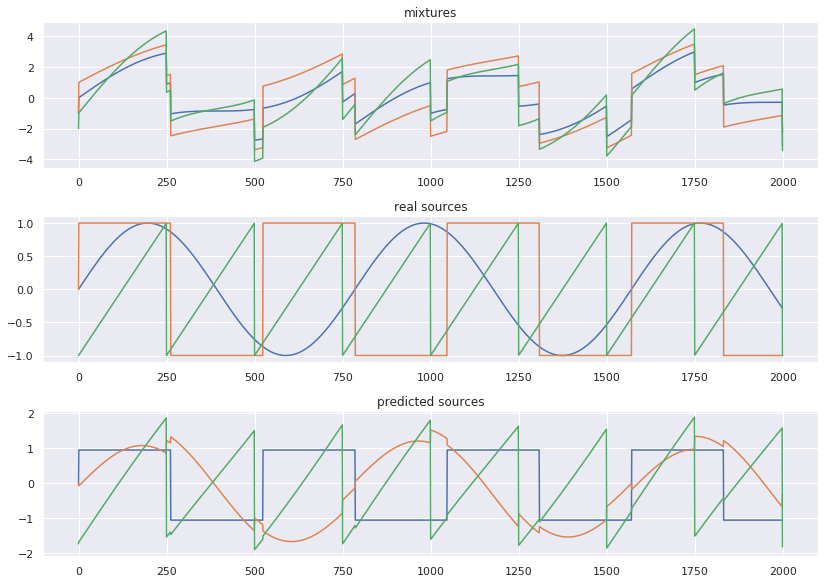

In [63]:
 run_for_toy_data()